<a href="https://colab.research.google.com/github/Vaycold/Python_DL/blob/main/Image_Transformation/%EC%BB%AC%EB%9F%AC%EC%82%AC%EC%A7%84%EC%9D%84%20%ED%9D%91%EB%B0%B1%EC%82%AC%EC%A7%84%EC%9C%BC%EB%A1%9C%20%EB%B0%94%EA%BE%B8%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from google.colab import drive
from IPython.display import Image

warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [3]:
dataset_path = 'MyDrive/MyDrive/fastcampus/DL_300/이미지변환/dataset'
pfcn_small = np.load(dataset_path + '/pfcn_small.npz')

In [4]:
train_images = pfcn_small['train_images']
test_images = pfcn_small['test_images']

## Pre-processing

In [5]:
train_images.shape

(1700, 100, 75, 3)

In [6]:
train_images.dtype

dtype('float64')

In [7]:
print(train_images.min(),train_images.max())
print(test_images.min(),test_images.max())

0.0 1.0
0.0 1.0


In [8]:
# 흑백이미지 생성
from skimage import color
print(train_images[0].shape)
print(color.rgb2gray(train_images[0]).shape) # 뒷부분 color부분이 없어짐

(100, 75, 3)
(100, 75)


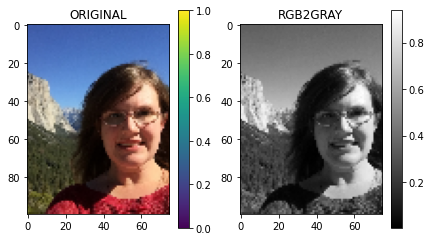

In [9]:
plt.figure(figsize=(7,4))

plt.subplot(121)
plt.title('ORIGINAL')
plt.imshow(train_images[0])
plt.colorbar()


plt.subplot(122)
plt.title('RGB2GRAY')
plt.imshow(color.rgb2gray(train_images[0]), cmap='gray')
plt.colorbar()
plt.show()

In [10]:
train_gray_images = np.array([color.rgb2gray(img).reshape((100,75,1)) for img in train_images])
test_gray_images = np.array([color.rgb2gray(img).reshape((100,75,1)) for img in test_images])

print(train_gray_images.shape)
print(test_gray_images.shape)

(1700, 100, 75, 1)
(300, 100, 75, 1)


## Modeling

In [11]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.layers import BatchNormalization, Dropout, Activation, concatenate
from keras.models import Model

In [12]:
def conv2d_block(x , channel) :
    x = Conv2D(channel, 3 , padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(channel, 3 , padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def unet_black() :
    inputs = Input((100,75,3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding= 'valid', output_padding=(0,1))(c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding= 'valid', output_padding=(1,0))(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding= 'valid', output_padding=(0,1))(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding= 'valid', output_padding=(0,1))(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(1,1, activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

In [13]:
model = unet_black()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 75, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [15]:
hist = model.fit(train_images, train_gray_images,
                 validation_data = (test_images, test_gray_images),
                 epochs = 10,
                 verbose = 1
)


Epoch 1/10
54/54 [==============================] - 39s 78ms/step - loss: 0.0278 - accuracy: 0.0106 - val_loss: 0.0545 - val_accuracy: 0.0181
Epoch 2/10
54/54 [==============================] - 3s 49ms/step - loss: 0.0046 - accuracy: 0.0114 - val_loss: 0.0468 - val_accuracy: 0.0181
Epoch 3/10
54/54 [==============================] - 3s 50ms/step - loss: 0.0027 - accuracy: 0.0111 - val_loss: 0.0365 - val_accuracy: 0.0181
Epoch 4/10
54/54 [==============================] - 3s 50ms/step - loss: 0.0020 - accuracy: 0.0126 - val_loss: 0.0262 - val_accuracy: 0.0181
Epoch 5/10
54/54 [==============================] - 3s 50ms/step - loss: 0.0017 - accuracy: 0.0127 - val_loss: 0.0169 - val_accuracy: 0.0181
Epoch 6/10
54/54 [==============================] - 3s 50ms/step - loss: 0.0016 - accuracy: 0.0131 - val_loss: 0.0099 - val_accuracy: 0.0181
Epoch 7/10
54/54 [==============================] - 3s 50ms/step - loss: 0.0016 - accuracy: 0.0105 - val_loss: 0.0053 - val_accuracy: 0.0181
Epoch 8/10
5

## Result


In [16]:
res = model.predict(test_images[1:2])
res.shape

(1, 100, 75, 1)

In [21]:
print(test_images[1:2].shape) # color
print(res.shape) # gray
print(test_gray_images[1:2].shape) # gray

(1, 100, 75, 3)
(1, 100, 75, 1)
(1, 100, 75, 1)


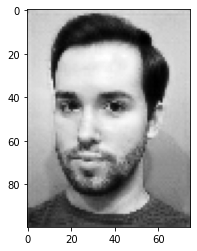

In [24]:
plt.imshow(res.reshape((100,-1)),cmap='gray')
plt.show()

In [27]:
test_gray_images[1].shape

(100, 75, 1)

In [26]:
res[0].shape

(100, 75, 1)

In [35]:
# 2개를 연달아서 확인해보자
img = np.concatenate(
    [res[0],
     test_gray_images[1]
    ]
).reshape(2,-1,75,1).transpose((1,0,2,3)).reshape((100,-1))
img.shape

(100, 150)

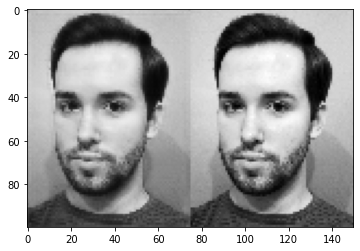

In [36]:
plt.imshow(img, cmap='gray')
plt.show()

In [37]:
# 5장 비교
five = model.predict(test_images[:5])
five.shape


(5, 100, 75, 1)

In [41]:
imgs = np.concatenate(
    [ five, test_gray_images[:5]], axis=1
).transpose((1,0,2,3)).reshape((200,-1))
imgs.shape

(200, 375)

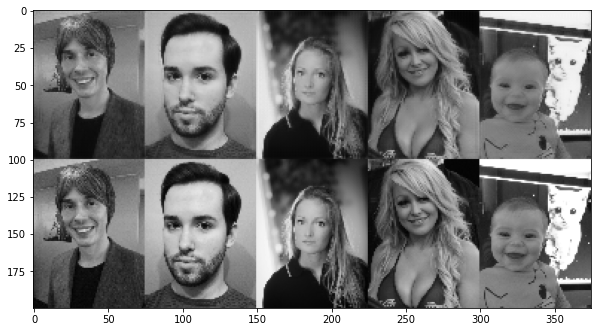

In [43]:
plt.figure(figsize=(10,7))
plt.imshow(imgs,cmap='gray')
plt.show()

## More simple model

In [52]:
def simple_black() :
    inputs = Input((100,75,3))
    x = Conv2D(30, 1, use_bias = False)(inputs)
    x = Conv2D(1, 1, use_bias = False)(x)
    model = Model(inputs, x)
    return model

In [53]:
model2 = simple_black()
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 75, 3)]      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 100, 75, 30)       90        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 100, 75, 1)        30        
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [54]:
model2.compile(
    loss = 'mae',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [55]:
hist2 = model2.fit(train_images, train_gray_images,
                   validation_data = (test_images, test_gray_images),
                   epochs = 10,
                   verbose = 1)

Epoch 1/10
54/54 [==============================] - 1s 13ms/step - loss: 0.4322 - accuracy: 0.0034 - val_loss: 0.0411 - val_accuracy: 0.0181
Epoch 2/10
54/54 [==============================] - 0s 9ms/step - loss: 0.0292 - accuracy: 0.0095 - val_loss: 0.0181 - val_accuracy: 0.0181
Epoch 3/10
54/54 [==============================] - 0s 9ms/step - loss: 0.0189 - accuracy: 0.0124 - val_loss: 0.0147 - val_accuracy: 0.0181
Epoch 4/10
54/54 [==============================] - 0s 9ms/step - loss: 0.0158 - accuracy: 0.0125 - val_loss: 0.0118 - val_accuracy: 0.0181
Epoch 5/10
54/54 [==============================] - 0s 9ms/step - loss: 0.0119 - accuracy: 0.0112 - val_loss: 0.0083 - val_accuracy: 0.0181
Epoch 6/10
54/54 [==============================] - 0s 9ms/step - loss: 0.0084 - accuracy: 0.0120 - val_loss: 0.0048 - val_accuracy: 0.0181
Epoch 7/10
54/54 [==============================] - 0s 9ms/step - loss: 0.0040 - accuracy: 0.0116 - val_loss: 0.0017 - val_accuracy: 0.0181
Epoch 8/10
54/54 [=

In [56]:
# result check

res2 = model2.predict(test_images[1:2])
res2.shape

(1, 100, 75, 1)

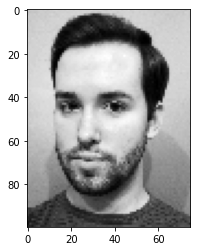

In [57]:
plt.imshow(res2.reshape((100,-1)), cmap='gray')

In [64]:
# model modifying
from keras import backend as K
def simple_black() :
    inputs = Input((100,75,3))
    x = Conv2D(30, 1, use_bias = False)(inputs)
    x = Conv2D(1, 1, use_bias = False)(x)
    x = K.clip(x, 0, 1) # x는 0이상 1이하로 잡아주는 역할
    model = Model(inputs, x)
    return model
model2 = simple_black()
model2.compile(
    loss = 'mae',
    optimizer = 'adam',
    metrics = ['accuracy'])
hist2 = model2.fit(train_images, train_gray_images,
                   validation_data = (test_images, test_gray_images),
                   epochs = 10,
                   verbose=1)

Epoch 1/10
54/54 [==============================] - 1s 12ms/step - loss: 0.4268 - accuracy: 0.0037 - val_loss: 0.0604 - val_accuracy: 0.0181
Epoch 2/10
54/54 [==============================] - 1s 9ms/step - loss: 0.0498 - accuracy: 0.0129 - val_loss: 0.0271 - val_accuracy: 0.0181
Epoch 3/10
54/54 [==============================] - 0s 9ms/step - loss: 0.0236 - accuracy: 0.0132 - val_loss: 0.0113 - val_accuracy: 0.0181
Epoch 4/10
54/54 [==============================] - 0s 9ms/step - loss: 0.0103 - accuracy: 0.0124 - val_loss: 0.0063 - val_accuracy: 0.0181
Epoch 5/10
54/54 [==============================] - 0s 9ms/step - loss: 0.0063 - accuracy: 0.0110 - val_loss: 0.0033 - val_accuracy: 0.0181
Epoch 6/10
54/54 [==============================] - 0s 9ms/step - loss: 0.0030 - accuracy: 0.0127 - val_loss: 0.0020 - val_accuracy: 0.0181
Epoch 7/10
54/54 [==============================] - 0s 9ms/step - loss: 0.0024 - accuracy: 0.0114 - val_loss: 0.0022 - val_accuracy: 0.0181
Epoch 8/10
54/54 [=

In [71]:
res2 = model2.predict(test_images)
res2.min(), res2.max()

(0.0, 1.0)

In [72]:
res2[2:3][0].shape

(100, 75, 1)

In [89]:
imgs = np.concatenate(
    [
     res2[2:3][0],
     test_gray_images[2]
    ], axis=1
)
imgs.shape

(100, 150, 1)

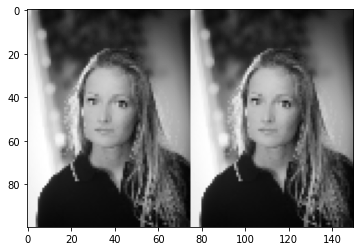

In [90]:
plt.imshow(imgs[:,:,0], cmap = 'gray')
plt.show()

In [ ]:
'''
def simple_black() :
    inputs = Input((100,75,3))
    x = Conv2D(30, 1, use_bias = False)(inputs) # 이 부분에서 30을 더 작은 수로 해도 가능하긴 함. 
    x = Conv2D(1, 1, use_bias = False)(x)
    x = K.clip(x, 0, 1) # x는 0이상 1이하로 잡아주는 역할
    model = Model(inputs, x)
    return model
'''

In [91]:
# 극단적인 선형 흑백 모델 // 0.30*R + 0.59*G + 0.11*B

def gray(x) :
    return (x + np.array([0.30, 0.59, 0.11])).sum(axis=2)

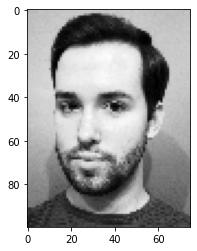

In [93]:
plt.imshow(gray(test_images[1]),cmap='gray')
plt.show()